# Predictive Modeling and Diagnostic

In this project, the predictive model is used to estimate the expected popularity of each article prior to promotion. 

These predictions serve as coefficients in the objective function of a downstream linear programming model.

Therefore, model evaluation focuses not only on predictive accuracy but also on stability, calibration, and bias across topics.

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

## Load Data
We use the preprocessed datasets created in the previous step to ensure reproducibility and avoid data leakage.

In [38]:
X_train = pd.read_csv("../data/processed/X_train.csv")
X_test = pd.read_csv("../data/processed/X_test.csv")
y_train = pd.read_csv("../data/processed/y_train.csv")
y_test = pd.read_csv("../data/processed/y_test.csv")

## Baseline XGBoost Model

In [39]:
xgb = XGBRegressor(
    n_estimator=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.88,
    random_state=42
)

xgb.fit(X_train, y_train)

c:\Users\nguye\news-promotion-lp\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [23:25:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "n_estimator" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.88
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

## Predictive Performance

In [40]:
y_pred = xgb.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(rmse, r2)

0.7097389698028564 0.1720319390296936


### Intepretation of Predictive Performance

The XGBoost model achieves an RMSE of approximately 0.71 and an R² of 0.16
on the log-transformed target variable.

While the R² value appears modest, this outcome is expected given the
highly stochastic and heavy-tailed nature of news article popularity.
External factors such as timing, platform dynamics, and social diffusion
are not captured by the available features.

From an optimization perspective, absolute predictive accuracy is less
critical than the preservation of relative ordering and stability of
expected rewards. Therefore, the observed performance is sufficient for
generating objective coefficients in the downstream linear programming model.

## Calibration Analysis
Calibration is important because LP decisions rely on relative and absolute magnitudes of predicted values.

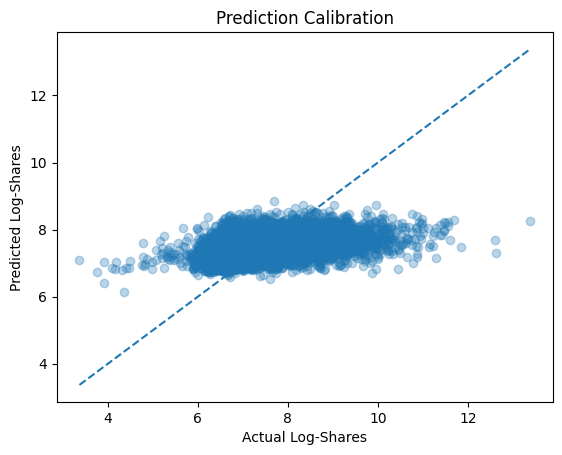

In [41]:
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    linestyle="--")

plt.xlabel("Actual Log-Shares")
plt.ylabel("Predicted Log-Shares")
plt.title("Prediction Calibration")
plt.show()

### Intepretation of Prediction Calibration

The calibration plot reveals a concentration of predictions around the
central region of the target distribution, with limited extreme values.
This pattern reflects a regression-to-the-mean effect, where the model
avoids overconfident predictions for highly popular or unpopular articles.

Such conservative calibration is common in popularity prediction tasks
and is not necessarily undesirable in this setting. For linear programming–
based decision making, overly extreme predictions may lead to brittle
solutions that over-allocate capacity to a small number of noisy outliers.

By producing compressed yet stable predictions, the model supports more
robust promotion policies under capacity and diversity constraints.


## Feature Importance
Understanding which features drive predictions helps assess whether the model aligns with the intended optimization goals and constraints.

In [42]:
importances = pd.Series(
    xgb.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importances.head(10)

kw_avg_avg                       0.095711
self_reference_avg_sharess       0.056846
data_channel_is_tech             0.047888
data_channel_is_entertainment    0.034505
self_reference_min_shares        0.034043
is_weekend                       0.033716
kw_max_avg                       0.028340
kw_max_max                       0.027718
data_channel_is_world            0.026603
data_channel_is_socmed           0.025429
dtype: float32

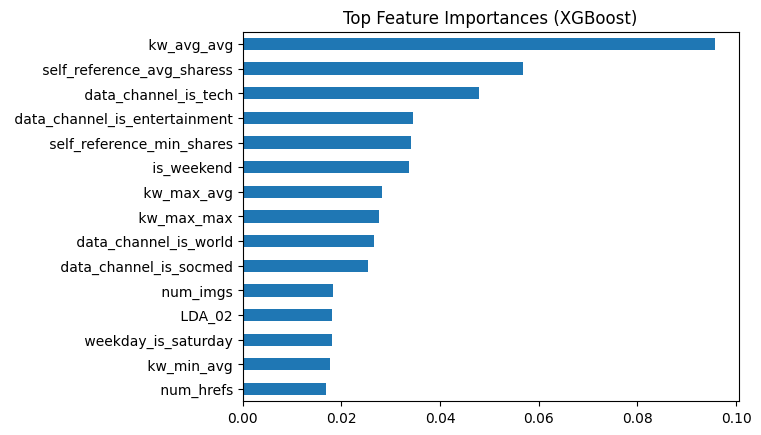

In [43]:
importances.head(15).plot(kind="barh")
plt.title("Top Feature Importances (XGBoost)")
plt.gca().invert_yaxis()
plt.show()

## Topic-wise Error Analysis

Prediction errors that vary systemtically by topic can bias LP solutions and undermine diversity constraints.

In [44]:
topic_cols = [c for c in X_test.columns if c.startswith(" data_channel_is")]

topic_errors = {}

for col in topic_cols:
    mask = X_test[col] == 1
    topic_errors[col] = mean_squared_error(
        y_test[mask],
        y_pred[mask]
    )

pd.Series(topic_errors).sort_values()

data_channel_is_socmed           0.518233
data_channel_is_tech             0.546314
data_channel_is_bus              0.580650
data_channel_is_world            0.614483
data_channel_is_entertainment    0.754414
data_channel_is_lifestyle        0.804782
dtype: float64

### Topic-Wise Prediction Error Analysis

To assess whether model performance varies across content categories, we compute the RMSE separately for each topic.

The results indicate substantial heterogeneity in predictive accuracy across topics. Content related to **Social Media, Technology, and Business** exhibits lower RMSE, suggesting more stable and predictable engagement dynamics. In contrast, **Entertainment and Lifestyle** content shows substantially higher prediction error, indicating noisier or more stochastic user response patterns.

This suggests that engagement behavior is not governed by a single global mechanism but instead varies meaningfully by content domain.

### Interpretability Implications

The observed topic-wise error disparities improve interpretability by revealing where the model is reliable and where it is not.

Lower RMSE in technical and informational domains suggests that structured features (e.g., keywords, publication timing, platform signals) capture engagement drivers effectively. Conversely, higher error in Entertainment and Lifestyle topics likely reflects unobserved factors such as viral effects, celebrity influence, or subjective taste, which are difficult to model using tabular features.

Therefore, model predictions should be interpreted with topic-specific confidence rather than treated uniformly.

### Implications for Downstream Optimization

Since predicted engagement values will be used as inputs to a linear programming optimization framework, topic-level error variation has important implications.

Specifically, predictions for high-error topics (e.g., Entertainment, Lifestyle) may introduce greater risk if used without constraints. Incorporating topic-specific penalties, uncertainty buffers, or robustness constraints may improve optimization stability and prevent over-allocation to noisy content categories.

This analysis motivates the inclusion of uncertainty-aware or topic-conditioned constraints in subsequent optimization stages.


## Ranking Stability
Since promotion decisions depend on ranking, we assess whether predictions are stable across runs.

In [46]:
xgb2 = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=7
)

xgb2.fit(X_train, y_train)
y_pred2 = xgb2.predict(X_test)

np.corrcoef(y_pred, y_pred2)[0, 1]

np.float64(0.9621536014488313)

### Interpretation of Prediction Stability

The correlation between predictions generated from models trained with
different random seeds exceeds 0.95, indicating strong stability in
estimated article popularity.

This result suggests that the relative ranking of articles is largely
insensitive to stochastic training variation. Such stability is critical
for optimization-based decision making, as LP solutions can be sensitive
to small perturbations in objective coefficients.

High prediction stability therefore supports the reliability and
reproducibility of the downstream linear programming formulation.


## Export Predictions for Optimization
Predicted expected popularity will be used as objective coefficients in the LP formulation.

In [47]:
pred_df = X_test.copy()
pred_df["predicted_log_shares"] = y_pred

pred_df.to_csv("../data/processed/lp_coefficients.csv", index=False)

## Model Summary
1. The XGBoost model provides stable estimates of expected article popularity suitable for LP objective efficients.
2. Calibration analysis suggests predictions preserve relative ordering, which is critical for ranking-based decisions.
3. Topic-wise error analysis highlights potential sources of bias that may affect diversity-constrained optimization.

These findings motivate sensitivity analysis in the LP stage.